In [1]:
# Class dependencies
from models.pytorch_model import OrigamiNetwork
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import minimize
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import pickle


# Other analysis libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from sklearn.datasets import load_digits

  0%|          | 0/300 [00:00<?, ?it/s]/Users/samlayton/Desktop/Work/Github/Open Source Repositories/FoldAndCutNetworks/model.py:1239: RuntimeWarning: overflow encountered in exp
  sigmoid = 1/(1 + np.exp(-p))
/Users/samlayton/Desktop/Work/Github/Open Source Repositories/FoldAndCutNetworks/model.py:1260: RuntimeWarning: overflow encountered in exp
  sigmoid = (1/(1 + np.exp(-p)))[:,np.newaxis, np.newaxis]
/Users/samlayton/Desktop/Work/Github/Open Source Repositories/FoldAndCutNetworks/model.py:1239: RuntimeWarning: overflow encountered in exp
  sigmoid = 1/(1 + np.exp(-p))
Epoch 1/300 - Train Acc: 0.0966 - Val Acc: 0.0764:   0%|          | 0/300 [00:00<?, ?it/s]/Users/samlayton/Desktop/Work/Github/Open Source Repositories/FoldAndCutNetworks/model.py:1239: RuntimeWarning: overflow encountered in exp
  sigmoid = 1/(1 + np.exp(-p))
/Users/samlayton/Desktop/Work/Github/Open Source Repositories/FoldAndCutNetworks/model.py:1260: RuntimeWarning: overflow encountered in exp
  sigmoid = (1/(1 +

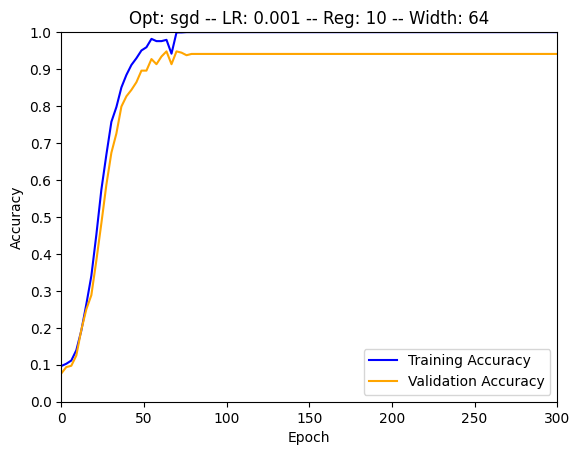

0.95


In [2]:
# import small digits dataset

digits = load_digits()
X = digits.data
y = digits.target

# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

# set up the model
model = OrigamiNetwork(layers=1, epochs=300, optimizer='sgd',learning_rate=0.001, sigmoid=True, crease=5)
model.fit(X_train, y_train, X_val, y_val)

# get the predictions
y_hat = model.predict(X_test)
print(accuracy_score(y_test, y_hat))

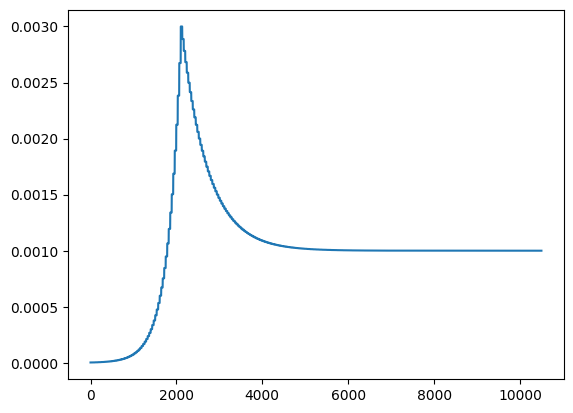

In [3]:
plt.plot(model.learning_rate_history)
plt.show()

In [33]:
def plot_boundary(model, title, h = .05, x_size = [-2, 2], y_size = [-2, 2], X = X_toy, y = Y_toy):
    x_min, x_max = x_size[0], x_size[1]
    y_min, y_max = y_size[0], y_size[1]
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    predictions = model.predict(grid_points)
    Z = np.array(predictions).reshape(xx.shape)

    # Plot the decision boundary using a contour plot
    plt.figure(figsize=(6, 6))
    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, alpha = .5, s=10)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(title)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.show()

def show_probs(model, title, h = .05, x_size = [-2, 2], y_size = [-2, 2],X=X_toy,y=Y_toy):
    x_min, x_max = x_size[0], x_size[1]
    y_min, y_max = y_size[0], y_size[1]
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    predictions = model.predict(grid_points, show_probabilities=True)[:,1]
    Z = np.array(predictions).reshape(xx.shape)

    # Plot the decision boundary using a contour plot
    plt.figure(figsize=(6, 6))
    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm, levels = 100)
    level_set = plt.contour(xx, yy, Z, levels=[0.5], colors='grey', linestyles='dashed', linewidths=.5)
    plt.clabel(level_set)
    print(np.max(X), np.min(X))
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, alpha = .5, s=10)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Decision Boundary')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.colorbar()


    # Plot the 3d plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(xx, yy, 1-Z, cmap='coolwarm')
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_zlabel('Probability of being in class 1')
    plt.show()

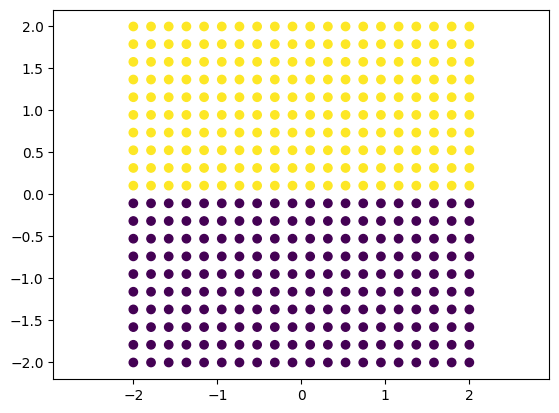

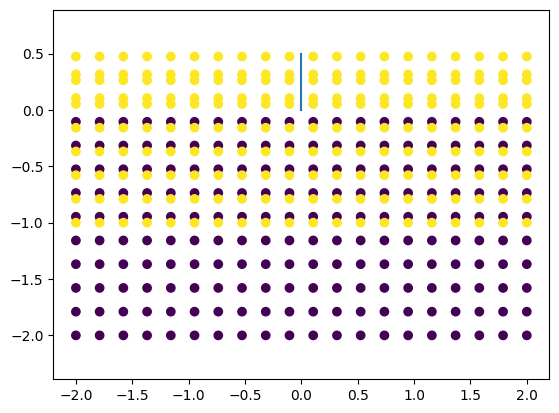

Epoch 1000/1000: 100%|██████████| 1000/1000 [00:01<00:00, 954.01it/s]


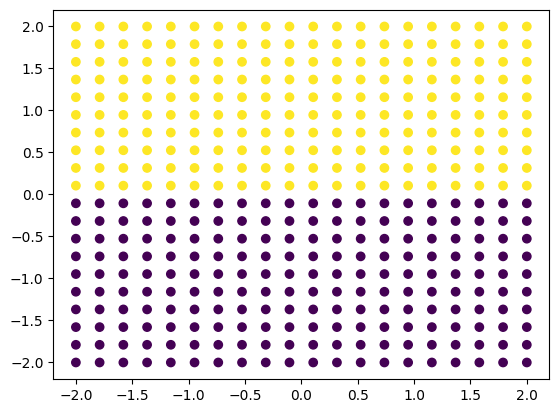

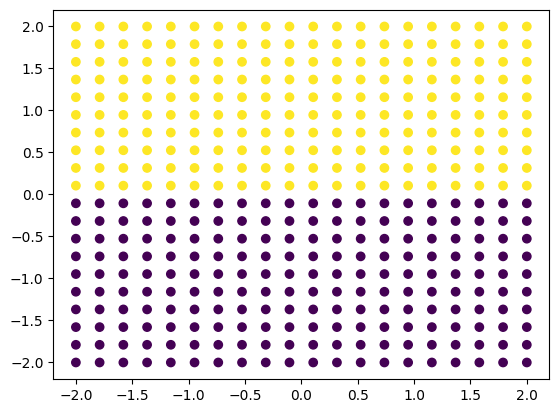

1.0


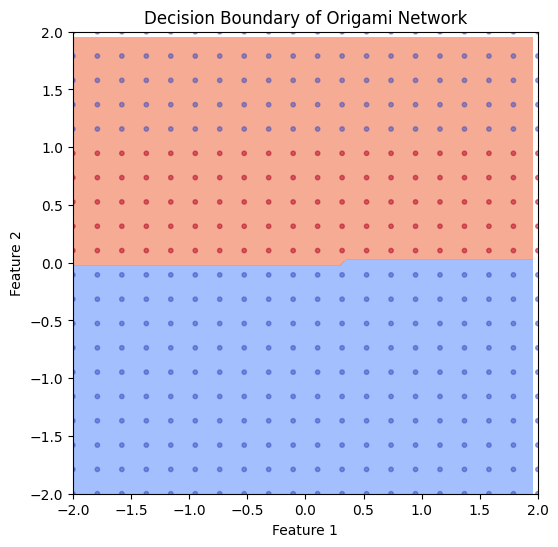

In [42]:
def layer(D, n):
    scales = (D@n)/np.dot(n, n)
    mask = scales > 1
    projected = 2 * np.outer(scales, n)
    adjustment = 2*n - projected
    return D + mask[:,np.newaxis] * adjustment

fv1 = .5*np.array([0,1])
# make a meshgrid of x and y values
x1 = np.linspace(-2,2,20)
x2 = np.linspace(-2,2,20)
X1,X2 = np.meshgrid(x1,x2)
# reshape the meshgrid into a 2D array and concatenate them
X1 = X1.reshape(-1,1)
X2 = X2.reshape(-1,1)
X_toy = np.concatenate((X1,X2),axis=1)
cut1 = layer(X_toy, fv1)
Y_toy = X_toy[:,1] > 0
plt.scatter(X_toy[:,0],X_toy[:,1], c = Y_toy)
plt.axis('equal')
plt.show()
plt.scatter(cut1[:,0],cut1[:,1], c = Y_toy)
plt.plot([0,fv1[0]],[0,fv1[1]])
plt.axis('equal')
plt.show()

# Make the model
test = OrigamiNetwork(layers = 1, learning_rate=0.01, reg=0, optimizer="sgd", batch_size=32, epochs=1000, sigmoid=False, crease=.50)
test.fit(X_toy,Y_toy)
out = test.forward_pass(X_toy)
for i in range(len(out)-1):
    plt.scatter(out[i][:,0],out[i][:,1], c = Y_toy)
    # plt.plot([0,test.fold_vectors[i][0]],[0,test.fold_vectors[i][1]])
    plt.show()
    
print(accuracy_score(Y_toy, test.predict(X_toy)))

plot_boundary(test, "Decision Boundary of Origami Network")

In [5]:

crease, width = 1.5, 2

def fold(Z, n):
    """
    This function folds the data along the hyperplane defined by the normal vector n
    
    Parameters:
        Z (n,d) ndarray - The data to fold
        n (d,) ndarray - The normal vector of the hyperplane
        leaky (float) - The amount of leak in the fold
    Returns:
        folded (n,d) ndarray - The folded data
    """
    # Make the scaled inner product and the mask
    scales = (Z@n)/np.dot(n, n)
    indicator = scales > 1

    # Make the projection and flip the points that are beyond the fold (mask)
    projected = np.outer(scales, n)
    folded = Z + 2 * indicator[:,np.newaxis] * (n - projected)
    return folded


def derivative_fold(Z, n):
    """
    This function calculates the derivative of the fold operation
    
    Parameters:
        Z (n,d) ndarray - The data to fold
        n (d,) ndarray - The normal vector of the hyperplane
        leaky (float) - The amount of leak in the fold
    Returns:
        derivative (n,d,d) ndarray - The derivative of the fold operation
    """
    # Get the scaled inner product, mask, and make the identity stack
    quad_normal = n / np.dot(n, n)
    scales = Z @ quad_normal
    indicator = scales > 1
    identity = np.eye(width)

    # Use broadcasting to apply scales along the first axis
    first_component = (1 - scales)[:, np.newaxis, np.newaxis] * identity
    
    # Calculate the outer product of n and helper, then subtract the input
    outer_product = np.outer(2 * scales, n) - Z
    second_component = np.einsum('ij,k->ijk', outer_product, quad_normal)
    
    # Return the derivative
    derivative = 2 * indicator[:,np.newaxis, np.newaxis] * (first_component + second_component)
    return derivative


def sig_fold(Z, n):
    """
    This function does a soft fold of the data along the hyperplane defined by the normal vector n
    Parameters:
        Z (n,d) ndarray - The data to fold
        n (d,) ndarray - The normal vector of the hyperplane
    Returns:
        folded (n,d) ndarray - The folded data
    """
    # Get the helpful terms to substitute into our fold function
    z_dot_x = (Z@n)
    n_dot_n = np.dot(n, n)
    scales = z_dot_x / n_dot_n
    p = crease * (z_dot_x - n_dot_n)
    sigmoid = 1/(1 + np.exp(-p))


    # Make the projection and flip the points that are beyond the fold
    projected = np.outer(1-scales, n)
    return Z + 2*sigmoid[:,np.newaxis] * projected


def sig_derivative_fold(Z, n):
    """
    This function calculates the derivative of the soft fold operation
    Parameters:
        Z (n,d) ndarray - The data to fold
        n (d,) ndarray - The normal vector of the hyperplane
    Returns:
        derivative (n,d,d) ndarray - The derivative of the fold operation
    """
    # Get the helpful terms to substitute into our derivative fold function
    z_dot_x = (Z@n)
    n_dot_n = np.dot(n, n)
    scales = z_dot_x / n_dot_n
    p = crease * (z_dot_x - n_dot_n)
    sigmoid = (1/(1 + np.exp(-p)))[:,np.newaxis, np.newaxis]
    u = n / n_dot_n
    identity_stack = np.stack([np.eye(width) for _ in range(len(Z))])
    one_minus_scales = 1 - scales[:,np.newaxis, np.newaxis]
        
    # Calculate the first component and the second, then combine them
    first_component = one_minus_scales * identity_stack
    second_component = np.einsum('ij,k->ijk', np.outer(2*Z@n, u) - Z, u)
    first_half = 2 * sigmoid * (first_component + second_component)
    
    # Calculate the second half of the derivative
    second_half = 2 * crease * one_minus_scales * sigmoid * (1-sigmoid) * np.einsum('ij,k->ijk', Z - 2*n[np.newaxis,:], n)
    return first_half + second_half


def test_diff(Z,n,eps, f, df):
    nudge1up = f(Z, fv1 + np.array([eps,0]))
    nudge1down = f(Z, fv1 - np.array([eps,0]))
    nudge2up = f(Z, fv1 + np.array([0,eps]))
    nudge2down = f(Z, fv1 - np.array([0,eps]))
    d1 = (nudge1up - nudge1down) / (2*eps)
    d2 = (nudge2up - nudge2down) / (2*eps)
    deriv = df(Z, n)
    autoderiv = np.zeros_like(deriv)
    autoderiv[:,0,:] = d1
    autoderiv[:,1,:] = d2
    return autoderiv, deriv


crease = 1.5
width = 2
autoderiv, deriv = test_diff(pairs, fv1, 1e-6, fold, derivative_fold)
print(np.allclose(autoderiv, deriv, atol=1e-12))
print(autoderiv - deriv)


True
[[[ 0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00]]

 [[ 0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00]]

 [[ 0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00]]

 ...

 [[-1.38475897e-10 -1.07021947e-10]
  [-2.60573785e-11 -5.75113290e-11]]

 [[ 1.30286892e-11 -1.07021947e-10]
  [-1.77561965e-10 -5.75113290e-11]]

 [[-2.79555934e-10 -3.29066552e-10]
  [ 1.15022658e-10  1.64533276e-10]]]
